# 2. Выбор модели

In [64]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.tree import DecisionTreeRegressor

In [65]:
# загрузка подготовленных данных в датафрейм
data = pd.read_csv("./data/data_prepared.csv")
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (308371, 128)


,baths,fireplace,sqft,zipcode,beds,target,Year built,Remodeled year,year_built_log,remodeled_year_log,...,fp_4,fp_5,fp_6,fp_7,fp_8,school_count,school_distance_min,school_distance_avg,school_rating_avg,school_rating_prx
0,3,1,2900.0,28387,4,418000.0,6,0,1.945910,0.000000,...,0,0,0,1,0,8,2.70,5.5,3.2,4.0
1,3,0,1947.0,99216,3,310000.0,6,0,1.945910,0.000000,...,0,0,0,0,0,3,1.01,1.3,2.7,4.0
2,2,1,3000.0,90049,3,2895000.0,64,58,4.174387,4.077537,...,0,0,0,0,0,3,1.19,2.0,6.7,8.0
3,8,1,6457.0,75205,5,2395000.0,19,19,2.995732,2.995732,...,0,0,0,0,0,4,0.10,0.8,6.8,9.0
4,0,0,897.0,19145,2,209000.0,105,0,4.663439,0.000000,...,0,0,0,0,0,0,1.10,2.8,4.2,5.2


In [66]:
# удаляем исходное поле
data = data.drop(labels=['target_log'], axis=1)

Разбиваем выборку

In [67]:
X = data.drop(['target'], axis=1)
y = data['target']
 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 42, test_size = 0.3)
# делим валидационный набор пополам для валидации и оценки
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, random_state = 42, test_size = 0.5)
# 
print('размер тренировочной выборки', X_train.shape[0])
print('размер валидационной выборки', X_valid.shape[0])
print('размер тестовой выборки', X_test.shape[0])
print('среднее значение целевой переменной на тренировочной выборке', round(y_train.mean(),2))

размер тренировочной выборки 215859
размер валидационной выборки 46256
размер тестовой выборки 46256
среднее значение целевой переменной на тренировочной выборке 479928.92


In [68]:
# оцениваем наивный прогноз по среднему значению
def mae_error(y, y_pred):
    mae = np.sum(abs(y_pred - y)) / len(y)
    return round(mae)

#Рассчитываем MAE
print(mae_error(y_test, np.mean(y_train))) # вычисляем ошибку

309326


Обучаем простую линейную регрессию. Для оценки выбираем метрики "среднее абсолютное отклонение" и R2-метрику

In [69]:
#Создаём объект класса LinearRegression
lr_lstat = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X_train, y_train)
#Предсказываем цену тестовой выборки
y_predict_train = lr_lstat.predict(X_train)
#Предсказываем цену тестовой выборки
y_predict = lr_lstat.predict(X_test)
#Рассчитываем MAE
print('MAE score: {:.3f} $'.format(metrics.mean_absolute_error(y_test, y_predict)))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_predict) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_predict_train)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_predict)))

MAE score: 224961.801 $
MAPE score: 117.423 %
Train R^2: 0.430
Test R^2: 0.433


Простая регрессия ненамного лучше наивного прогноза, необходимы более продвинутые методы построения модели

### Отбираем лучшие признаки и строим матрицу корреляций

In [70]:
# с помощью SelectKBest отберите 10 наиболее подходящих признаков
selector = SelectKBest(f_regression, k=10).fit(X_train, y_train)
col_names = selector.get_feature_names_out()
col_names

array(['baths', 'fireplace', 'sqft', 'beds', 'sqft_log', 'pool',
       '1_story', 'type_34', 'school_rating_avg', 'school_rating_prx'],
      dtype=object)

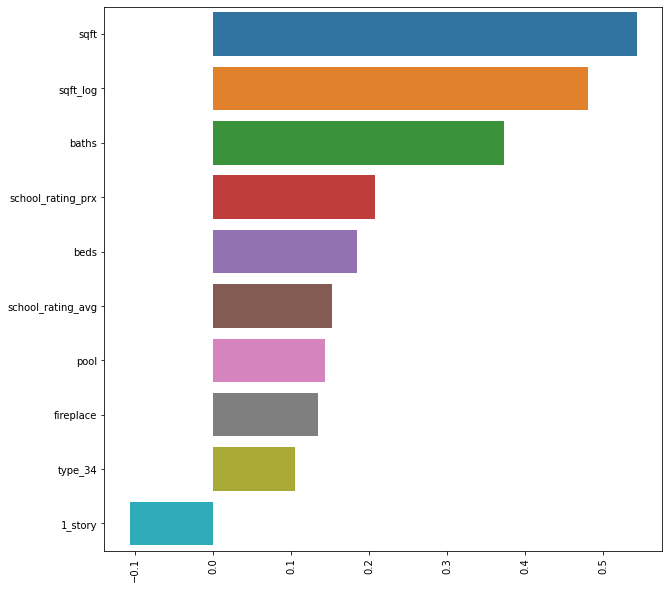

In [71]:
corr_matrix = data[np.append(col_names, 'target')].corr() # корреляционная матрица признаков
corr_matrix.drop(labels=['target'], inplace=True, axis=0)
# строим столбчатую диаграмму для коэффициентов корреляции
fig = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
bar1 = sns.barplot(
             y = list(corr_matrix['target'].sort_values(ascending=False).keys()),
             x = list(corr_matrix['target'].sort_values(ascending=False)),
             orient='h'
            )
bar1.tick_params(axis='x', rotation=90);

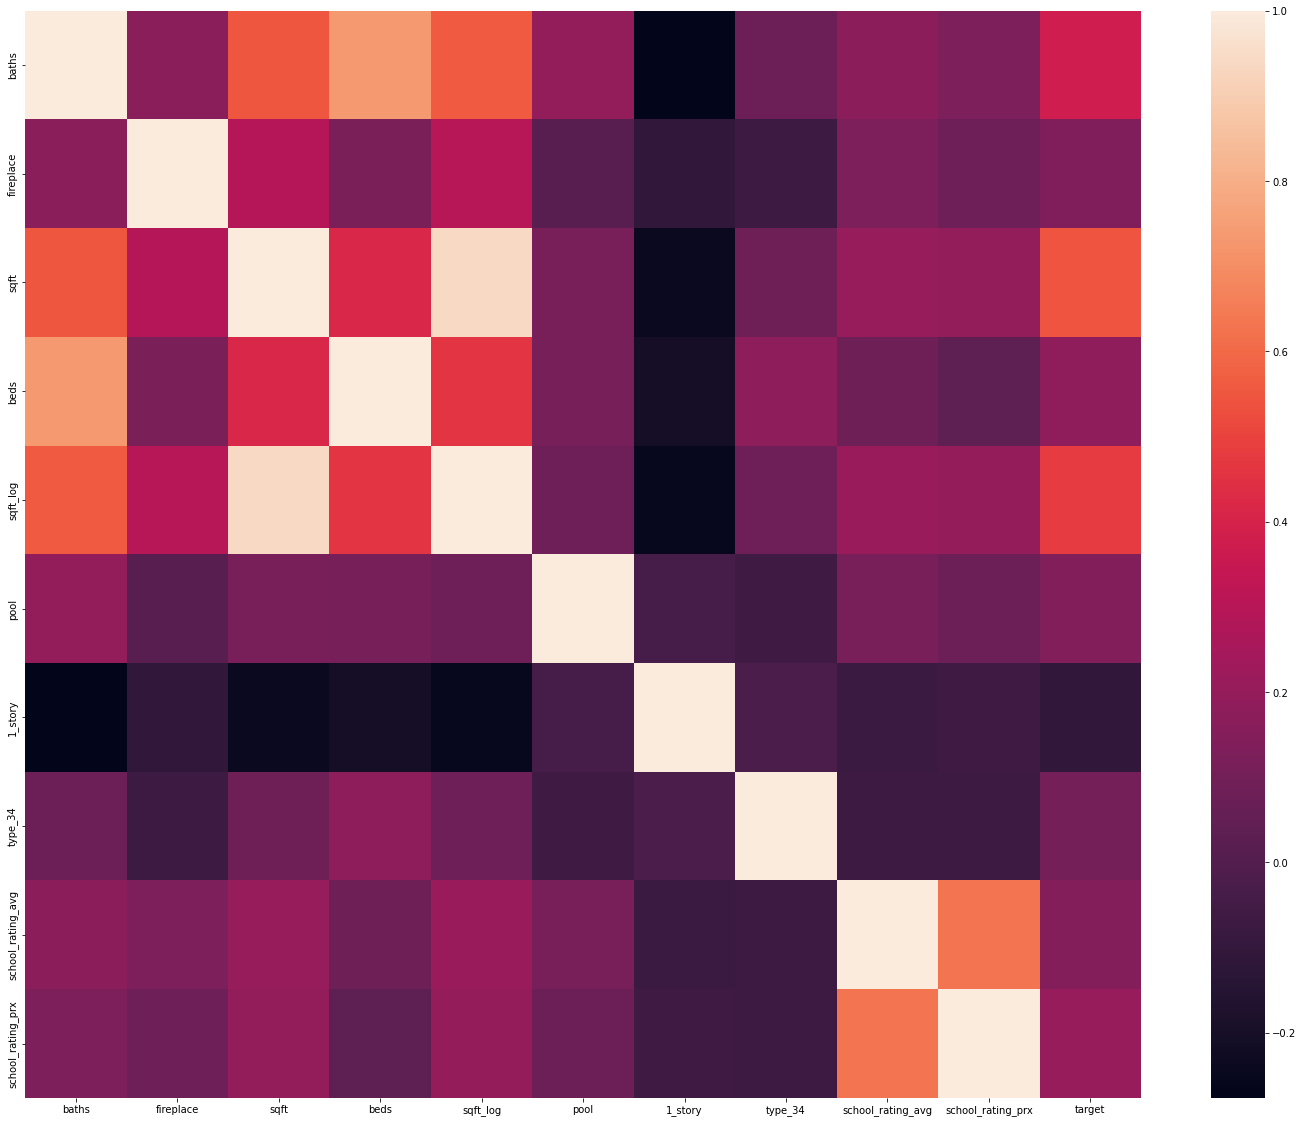

In [72]:
# строим тепловую карту для матрицы корреляции
fig = plt.subplots(nrows=1, ncols=1, figsize=(25,20))
heatmap = sns.heatmap(corr_matrix)

Сильно коррелирующие признаки:
sqft - sqft_log
beds - baths

Нормализация небинарных признаков

In [73]:
# делим признаки на бинарные и небинарные
a = X_train.describe().loc['max']
binary_columns = list(a[a==1].keys())
nonbinary_columns = list(a[a>1].keys())
nonbinary_columns

['baths',
 'fireplace',
 'sqft',
 'zipcode',
 'beds',
 'Year built',
 'Remodeled year',
 'year_built_log',
 'remodeled_year_log',
 'lot_size',
 'lot_size_log',
 'sqft_log',
 'school_count',
 'school_distance_min',
 'school_distance_avg',
 'school_rating_avg',
 'school_rating_prx']

In [74]:
#Инициализируем стандартизатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train[nonbinary_columns])
#Производим стандартизацию тренировочной выборки
X_train_nb_mm = scaler.transform(X_train[nonbinary_columns])
#Производим стандартизацию тестовой выборки
X_test_nb_mm = scaler.transform(X_test[nonbinary_columns])
#Производим стандартизацию тестовой выборки
X_valid_nb_mm = scaler.transform(X_valid[nonbinary_columns])

#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train_nb_mm)
#Производим стандартизацию тренировочной выборки
X_train_nb_scaled = scaler.transform(X_train_nb_mm)
#Производим стандартизацию тестовой выборки
X_test_nb_scaled = scaler.transform(X_test_nb_mm)
#Производим стандартизацию тестовой выборки
X_valid_nb_scaled = scaler.transform(X_valid_nb_mm)

# соединяем с бинарными признаками
X_train_scaled = np.concatenate((np.array(X_train[binary_columns]), X_train_nb_scaled), axis=1)
X_test_scaled = np.concatenate((np.array(X_test[binary_columns]), X_test_nb_scaled), axis=1)
X_valid_scaled = np.concatenate((np.array(X_valid[binary_columns]), X_valid_nb_scaled), axis=1)
#
X_train_scaled = pd.DataFrame(X_train_scaled, columns=binary_columns+nonbinary_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=binary_columns+nonbinary_columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=binary_columns+nonbinary_columns)

Пробуем регрессию на полиномиальных признаках 2й степени

In [75]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled[col_names])
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled[col_names])
#Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled[col_names])
#Выводим результирующие размерности таблиц
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(215859, 65)
(46256, 65)


In [76]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=5)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict_poly)))
#Рассчитываем MAPE
print('MAPE score: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict_poly) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

MAE score: 232226 $
MAPE score: 145 %
Train R^2: 0.391
Test R^2: 0.396


Результаты по прежнему неудовлетворительные. Использование полиномиальной регрессии улучшило результаты, но для практического применения этого недостаточно

### Попробуем использовать дерево решений. Подберем оптимальную глубину древа

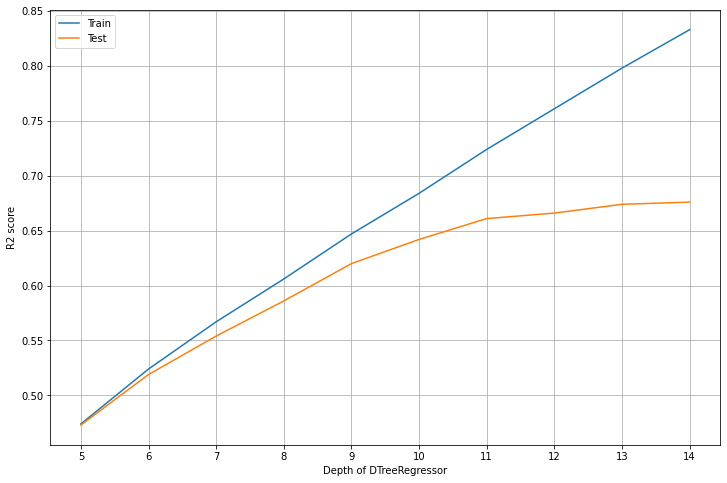

In [77]:
max_depths = range(5,15)
train_score = []
test_score = []
for n in max_depths:
    dt = DecisionTreeRegressor(random_state = 42, max_depth=n)
    dt.fit(X_train_scaled, y_train)
    y_train_pred = dt.predict(X_train_scaled)
    y_test_pred = dt.predict(X_test_scaled)
    train_score.append(round(metrics.r2_score(y_train, y_train_pred),3))
    test_score.append(round(metrics.r2_score(y_test, y_test_pred),3))

fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=max_depths, y=train_score, label='Train')
sns.lineplot(x=max_depths, y=test_score, label='Test')
ax.set_xlabel('Depth of DTreeRegressor')
ax.set_ylabel('R2 score')
ax.set_xticks(max_depths)
ax.grid()

In [78]:
dt = DecisionTreeRegressor(random_state = 42, max_depth=11)
dt.fit(X_train_scaled, y_train)

#Предсказываем цену тестовой выборки
y_predict_train = dt.predict(X_train_scaled)
y_test_predict = dt.predict(X_test_scaled)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
#Рассчитываем MAPE
print('MAPE score: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_predict_train)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

MAE score: 158913 $
MAPE score: 82 %
Train R^2: 0.724
Test R^2: 0.661


Результаты лучше чем у регрессии

### Применяем ансамблевые методы

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [80]:
#Создаем объект класса случайный лес
rf = RandomForestRegressor(
    n_estimators = 100,
    max_depth = 12,
    criterion = 'squared_error',
    random_state = 42
    )

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Предсказываем результат и Выводим значения метрик
y_train_predict = rf.predict(X_train_scaled)
y_test_predict = rf.predict(X_test_scaled)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
#Рассчитываем MAPE
print('MAPE score: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_predict_train)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

MAE score: 139952 $
MAPE score: 72 %
Train R^2: 0.724
Test R^2: 0.742


In [81]:
# Градиентный бустинг
gb = GradientBoostingRegressor(
    learning_rate=0.2, #темп обучения
    n_estimators=100, #число деревьев
    max_depth=12, #максимальная глубина дерева
    random_state=42
)
gb.fit(X_train_scaled, y_train)
#Предсказываем результат и Выводим значения метрики 
y_train_predict = gb.predict(X_train_scaled)
y_test_predict = gb.predict(X_test_scaled)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
#Рассчитываем MAPE
print('MAPE score: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_predict_train)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

MAE score: 96094 $
MAPE score: 32 %
Train R^2: 0.724
Test R^2: 0.845


Пробуем XGBoost

In [82]:
xgb = XGBRegressor(
        objective='reg:squarederror'
)
xgb.fit(X_train_scaled, np.array(y_train))
y_test_predict = xgb.predict(X_test_scaled)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
print(f'Качество предсказания r2_score {round(metrics.r2_score(y_test, y_test_predict),3)}')

MAE score: 119481 $
Качество предсказания r2_score 0.795


В том числе, не удалось подобрать оптимальную стекинг-схему, дающую сколько нибудь приличный результат

В итоге: Градиентный бустинг показывает лучшие результаты. Остановимся на этом типе модели

# 3. Подбор гиперпараметров

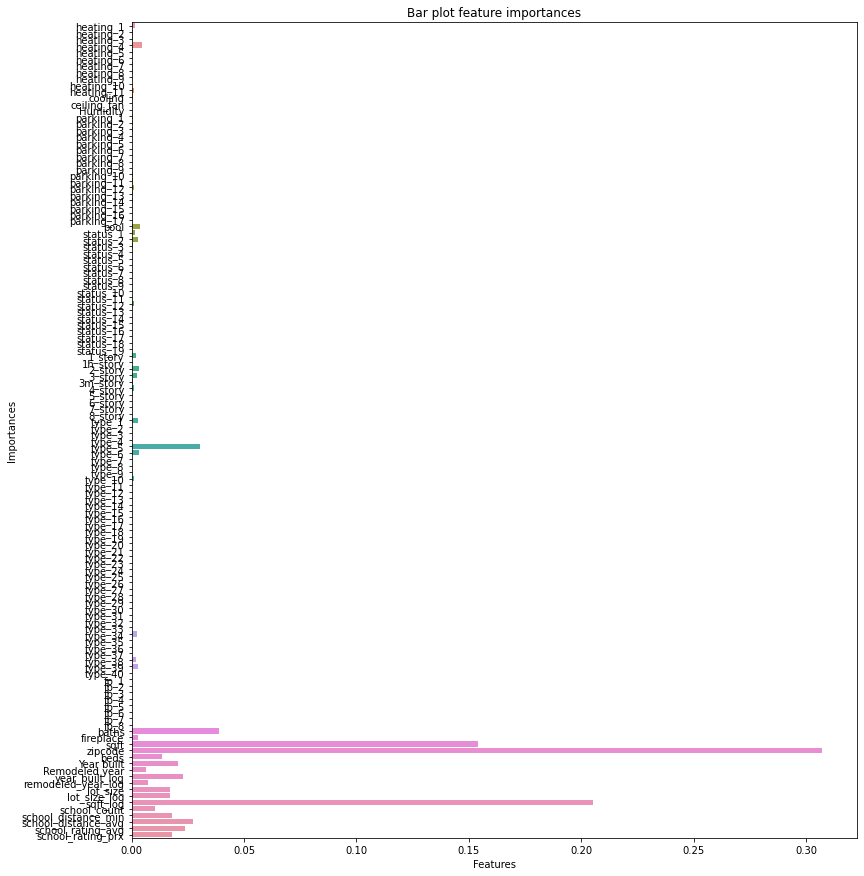

In [83]:
# отбираем выжные признаки для градиентного бустинга
fig, ax = plt.subplots(figsize=(13, 15)) #фигура + координатная плоскость
feature = X_train_scaled.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(y=feature, x=feature_importances, ax=ax, orient='h');
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

Отбираем наиболее значимые для градиентного бустинга признаки для подбора гиперпараметров

In [84]:
ff = pd.DataFrame( 
                  np.concatenate( 
                                 (np.array(feature).reshape(feature.shape[0],1), 
                                  np.array(feature_importances).reshape(feature_importances.shape[0],1)
                                  ), axis=1), 
                  columns=['feature', 'val']
                  )
ff[ff['val']>0.001]['feature'].values

array(['heating_1', 'heating_4', 'heating_11', 'pool', 'status_1',
       'status_2', '1_story', '2_story', '3_story', '4_story', 'type_1',
       'type_5', 'type_6', 'type_10', 'type_34', 'type_38', 'type_39',
       'baths', 'fireplace', 'sqft', 'zipcode', 'beds', 'Year built',
       'Remodeled year', 'year_built_log', 'remodeled_year_log',
       'lot_size', 'lot_size_log', 'sqft_log', 'school_count',
       'school_distance_min', 'school_distance_avg', 'school_rating_avg',
       'school_rating_prx'], dtype=object)

In [85]:
gb_columns = ['heating_1', 'heating_4', 'heating_11', 'pool', 'status_1',
       'status_2', '1_story', '2_story', '3_story', 'type_1', 'type_5',
       'type_6', 'type_10', 'type_34', 'type_38', 'type_39', 'baths',
       'fireplace', 'sqft', 'zipcode', 'beds', 'Year built',
       'Remodeled year', 'year_built_log', 'remodeled_year_log',
       'lot_size', 'lot_size_log', 'sqft_log', 'school_count',
       'school_distance_min', 'school_distance_avg', 'school_rating_avg',
       'school_rating_prx']
# 'school_distance_min_log',       'school_distance_avg_log'

In [86]:
X_train_scaled = X_train_scaled[gb_columns]
X_valid_scaled = X_valid_scaled[gb_columns]
X_test_scaled = X_test_scaled[gb_columns]

In [87]:
#делаем импорт и выведем версию библиотеки
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.0.4


In [88]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 80, 180, 10)
  max_depth = trial.suggest_int('max_depth', 5, 15, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10, 1)

  # создаем модель
  model = GradientBoostingRegressor(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    min_samples_split=min_samples_split,
                                    random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.r2_score(y_valid, model.predict(X_valid_scaled))

  return score  

In [89]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="GradientBoostingRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2023-11-17 14:46:59,183] A new study created in memory with name: GradientBoostingRegressor


[I 2023-11-17 14:56:23,483] Trial 0 finished with value: 0.8507679524080924 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 7}. Best is trial 0 with value: 0.8507679524080924.
[I 2023-11-17 15:01:06,234] Trial 1 finished with value: 0.8361117328928349 and parameters: {'n_estimators': 110, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}. Best is trial 0 with value: 0.8507679524080924.
[I 2023-11-17 15:05:40,527] Trial 2 finished with value: 0.840221780843128 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_leaf': 7, 'min_samples_split': 6}. Best is trial 0 with value: 0.8507679524080924.
[I 2023-11-17 15:10:33,755] Trial 3 finished with value: 0.8181954011391979 and parameters: {'n_estimators': 150, 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 7}. Best is trial 0 with value: 0.8507679524080924.
[I 2023-11-17 15:15:56,024] Trial 4 finished with value: 0.8316734287820924 and parameters: {'

CPU times: total: 51min 2s
Wall time: 51min 29s


In [90]:
optuna.visualization.plot_optimization_history(study, target_name="r2_score")

In [91]:
optuna.visualization.plot_param_importances(study, target_name="r2_score")

# 4. Обучение и сериализация модели

In [93]:
# Градиентный бустинг
gb = GradientBoostingRegressor(
    learning_rate=0.1, #темп обучения
    n_estimators=140, #число деревьев
    max_depth=15, #максимальная глубина дерева
    min_samples_leaf = 3,
    min_samples_split = 7,
    random_state=42 #генератор случайных чисел
)
gb.fit(X_train_scaled, y_train)
#Предсказываем результат и Выводим значения метрики 
y_train_predict = gb.predict(X_train_scaled)
y_test_predict = gb.predict(X_test_scaled)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
#Рассчитываем MAPE
print('MAPE score: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

In [ ]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('./web_app/app/models/model.pkl', 'wb') as output:
    pickle.dump(gb, output)

In [ ]:
X_test_scaled.loc[4].values

array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.2163064 , -0.63090607,  1.00746778,  0.89683288,
        0.75269365, -0.98306529, -0.72175106, -0.83519033, -0.89838434,
       -0.01079481,  0.3046641 ,  1.1550326 , -0.05007235, -0.11633118,
       -0.20226958,  0.69935238,  0.91646535, -0.19786638, -0.30033548])

In [ ]:
X_test_scaled.loc[4].keys()

Index(['heating_1', 'heating_4', 'heating_11', 'pool', 'status_1', 'status_2',
       '1_story', '2_story', '3_story', 'type_1', 'type_5', 'type_6',
       'type_10', 'type_34', 'type_38', 'type_39', 'baths', 'fireplace',
       'sqft', 'zipcode', 'beds', 'Year built', 'Remodeled year',
       'year_built_log', 'remodeled_year_log', 'lot_size', 'lot_size_log',
       'sqft_log', 'school_count', 'school_distance_min',
       'school_distance_avg', 'school_rating_avg', 'school_rating_prx',
       'school_distance_min_log', 'school_distance_avg_log'],
      dtype='object')